# Fruit Classification
Group: Hannah Li, Trisha Paul, Puja Subramaniam, Shelby Watson

In [16]:
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')
import cv2
import os
import re
import numpy as np
import pandas as pd
from pandas import DataFrame,Series

#for feature extraction
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
%matplotlib inline
%pylab inline

#for basic models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#for CNN & Inception v3
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.applications import inception_v3

Populating the interactive namespace from numpy and matplotlib


## Unzipping fruits.zip, separating into train and test sets
Contains train and test images

In [2]:
with ZipFile('fruits.zip', 'r') as zipObj:
    listOfiles = zipObj.namelist()

In [3]:
#first row is README so drop it
df = pd.DataFrame(listOfiles[1:], columns = ['image path']) 

#separate into training and test sets
fruits_test = []
fruits_train = []

for mystring in df['image path']:
    if 'Test' in mystring: 
            fruits_test.append(mystring)

for mystring in df['image path']:
    if 'Training' in mystring: 
            fruits_train.append(mystring)
fruits_test = pd.DataFrame(fruits_test, columns = ['image path'])
fruits_train = pd.DataFrame(fruits_train, columns = ['image path'])

#add label to image in dataframe
#do regex to extract label from image path
res = []
for i in fruits_train['image path']:
    res.append(re.findall("Training/(nt|[a-zA-Z\s+]+)", i)[0])
fruits_train['label'] = res

test_res = []
for i in fruits_test['image path']:
    test_res.append(re.findall("Test/(nt|[a-zA-Z\s+]+)", i)[0])
fruits_test['label'] = test_res

In [4]:
#cv2 reference: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_image_display/py_image_display.html
fruit_images = []
labels = [] 

for i in range(len(fruits_train)):
    #read in image in color
    image = cv2.imread(fruits_train['image path'][i], cv2.IMREAD_COLOR)
    image = cv2.resize(image, (45, 45))
    #inverse image colors to show appropriately on screen (RGB to BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)    
    fruit_images.append(image)
    labels.append(fruits_train['label'][i])

#array of fruit images    
fruit_images = np.array(fruit_images)

#creating labels for images
labels = np.array(labels)
label2id = {v:i for i,v in enumerate(np.unique(labels))}
label_ids = np.array([label2id[x] for x in labels])

## PCA

In [5]:
#scaling and default PCA on entire training set of images
scaler = StandardScaler()
images_scaled = scaler.fit_transform([i.flatten() for i in fruit_images])
pca = PCA().fit(images_scaled)

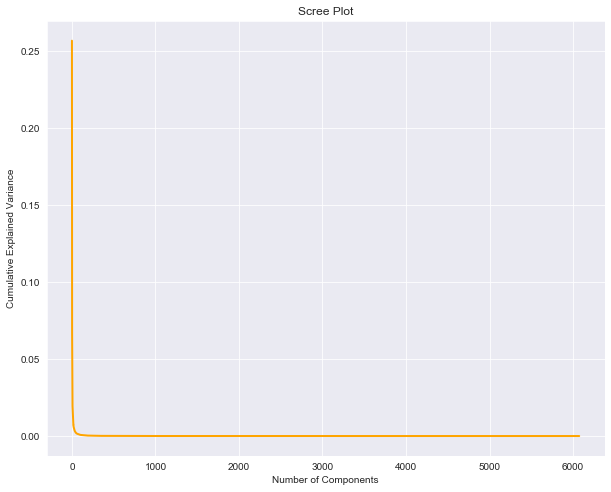

In [6]:
#scree plot for entire traiing set of images
sns.set_style("darkgrid")
plt.figure(figsize = (10,8))
plt.plot(pca.explained_variance_ratio_, color = 'orange', linewidth = 2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

Getting optimal number of components

In [7]:
explained_var = list(pca.explained_variance_ratio_)
shifted_var = explained_var
var_df = DataFrame()
var_df['explained_var'] = explained_var
var_df['shifted_var'] = shifted_var
var_df['shifted_var'] = var_df['shifted_var'].shift(-1)
var_df['shifted_var'].fillna(0)
var_df['difference'] = var_df['explained_var'] - var_df['shifted_var']
v = var_df[var_df['difference'] < .00004].reset_index()
v = v.rename(columns={'index': 'components'})
v.iloc[4]
#50 components explains 99% (1-.000037) variance

components       50.000000
explained_var     0.002001
shifted_var       0.001964
difference        0.000037
Name: 4, dtype: float64

PCA with optimal number of components (50)

Showing PCA on 400 images randomly sampled from fruits_train set (for visual purposes to understand and see PCA).

In [8]:
sampledf = fruits_train.sample(n = 400, replace=True, random_state=1).reset_index(drop = True)

sample_images = []
sample_labels = [] 

for i in range(len(sampledf)):
    image = cv2.imread(sampledf['image path'][i], cv2.IMREAD_COLOR)
    image = cv2.resize(image, (45, 45))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)    
    sample_images.append(image)
    sample_labels.append(sampledf['label'][i])  
sample_images = np.array(sample_images)

Before PCA on sample set

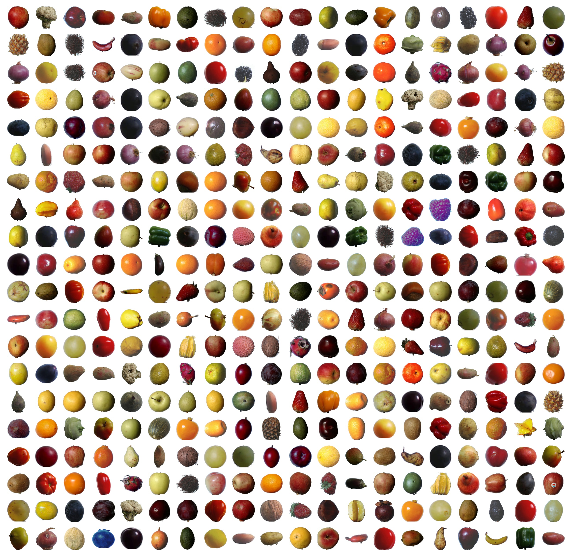

In [9]:
fig, axes = plt.subplots(20, 20, figsize = (10,10))
for i, ax in enumerate(axes.flat):
    ax.axis('off')
    ax.imshow(sample_images[i])

After PCA (50 components) on sample set

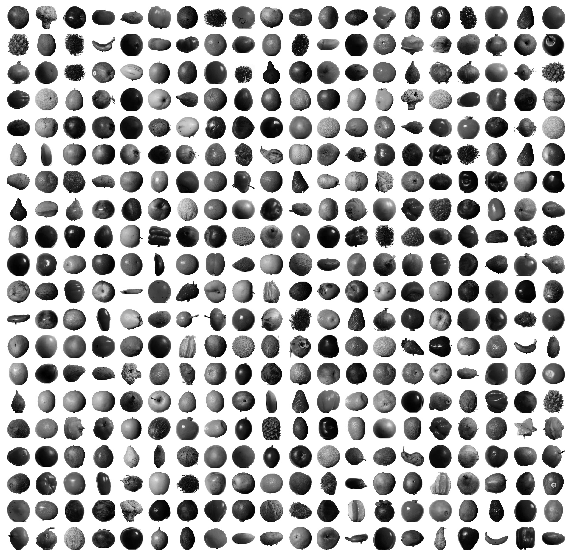

In [10]:
sample_fruits = pd.DataFrame([])
subset = sampledf['image path']
for x in subset:
    img = mean(mpimg.imread(x), 2)
    sfruit = pd.Series(img.flatten(), name=x)
    sample_fruits = sample_fruits.append(sfruit)
    
#fit transform pca onto sample for visual purposes...will reset later
lower_dimensional_data = pca.fit_transform(sample_fruits)
app = pca.inverse_transform(lower_dimensional_data)

fig, axes = plt.subplots(20, 20, figsize = (10,10))
for i, ax in enumerate(axes.flat):
    ax.axis('off')
    ax.imshow(app[i].reshape(100,100), cmap = 'gray')

In [11]:
pca = PCA(n_components=50)
pca_result = pca.fit_transform(images_scaled)

## TSNE Plot
Use TSNE plot to visually see how entire train set images are grouped after PCA is performed

In [12]:
tsne = TSNE(n_components=2, perplexity=40.0)
tsne_result = tsne.fit_transform(pca_result)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

In [13]:
tsnedf = DataFrame()
tsnedf['x'] = list(tsne_result_scaled[:,0])
tsnedf['y'] = list(tsne_result_scaled[:,1])
tsnedf['label'] = labels
tsnedf

,x,y,label
0,1.277426,0.465282,Apple Braeburn
1,1.301594,0.332069,Apple Braeburn
2,1.302222,0.332307,Apple Braeburn
3,1.303056,0.332692,Apple Braeburn
4,1.303648,0.332977,Apple Braeburn
5,1.304701,0.333515,Apple Braeburn
6,1.305385,0.333864,Apple Braeburn
7,1.302301,0.332111,Apple Braeburn
8,1.302779,0.332340,Apple Braeburn
9,1.303338,0.332573,Apple Braeburn


Scatter Plot

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

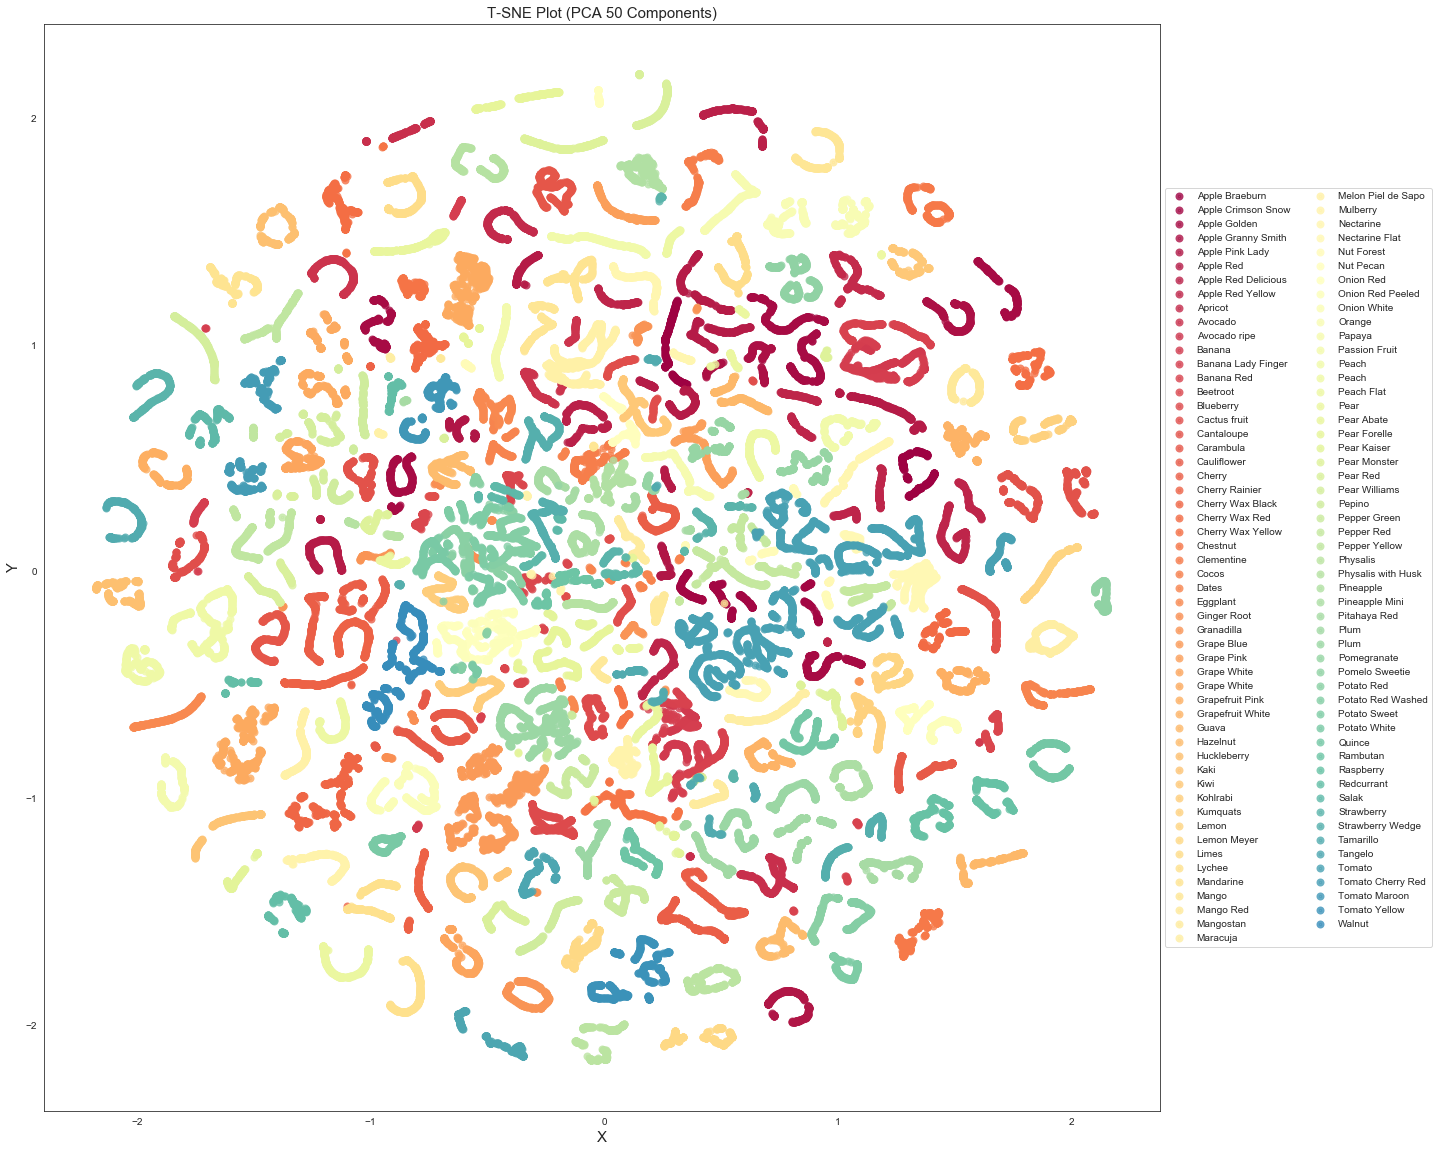

In [273]:
nb_classes = len(np.unique(label_ids))
sns.set_style('white')
#120 for 120 fruits, so 120 different colors
cmap = plt.cm.get_cmap("Spectral", 120) 

plt.figure(figsize=(20,20))
for i, label_id in enumerate(np.unique(label_ids)):
    
    #plot matching labels to tsne results so labels are accurate
    plt.scatter(tsne_result_scaled[np.where(label_ids == label_id), 0],
                tsne_result_scaled[np.where(label_ids == label_id), 1],
                marker = '.',
                c = cmap(i),
                linewidth = '5',
                alpha=0.8,
                label = id2label[label_id])
plt.title('T-SNE Plot (PCA 50 Components)', fontsize = 15)
plt.xlabel('X', fontsize = 15)
plt.ylabel('Y', fontsize = 15)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 2)
plt.show()

Image Plot

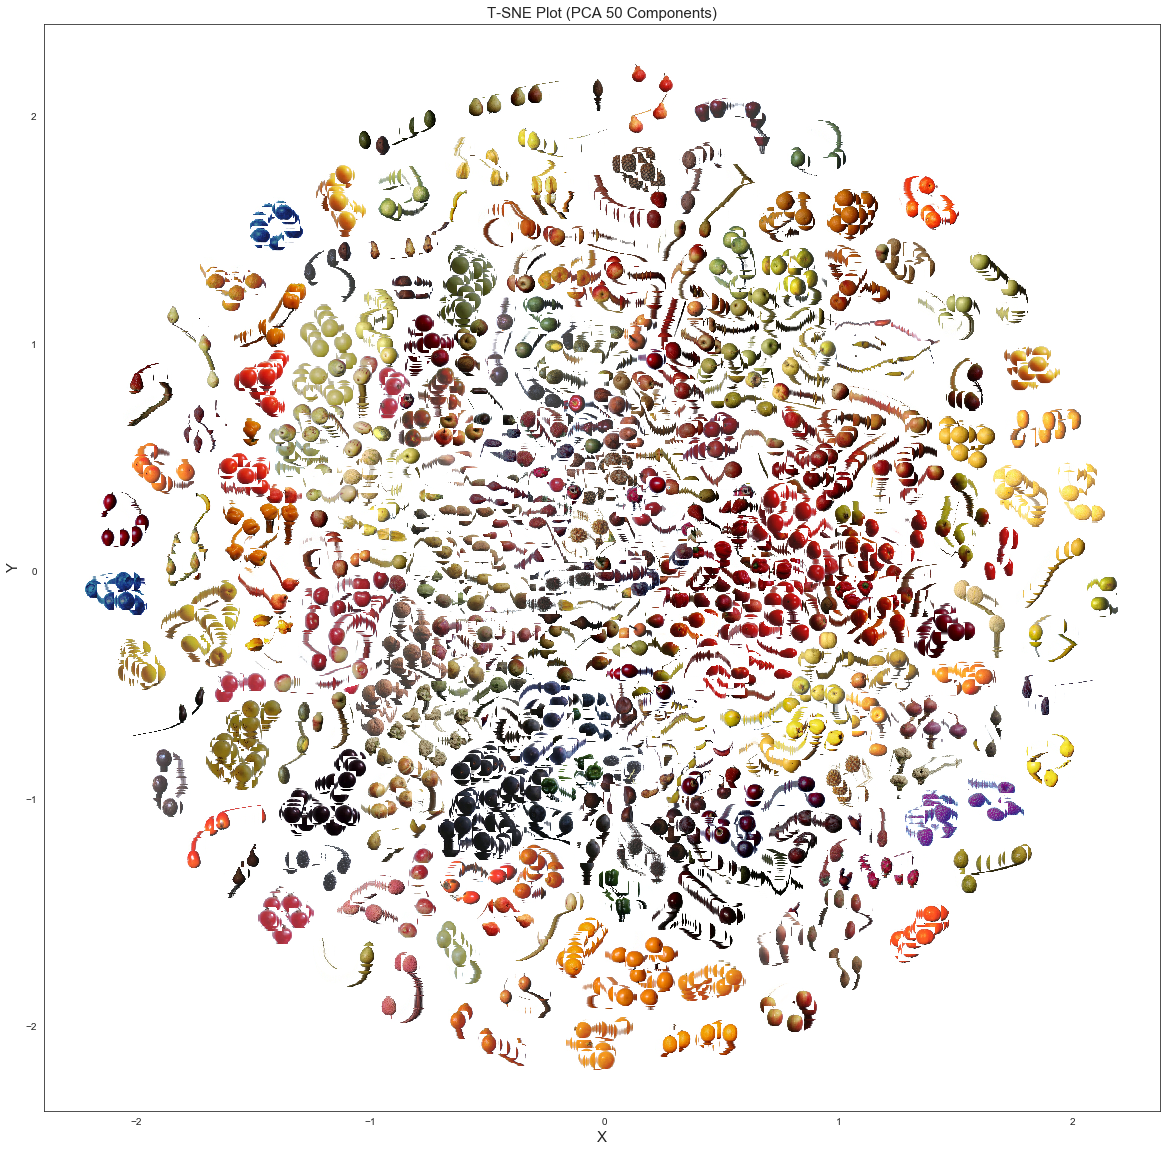

In [274]:
fig, ax = plt.subplots(figsize=(20,20))
for df, i in zip(tsnedf.iterrows(), fruit_images):
    x = df[1]['x']
    y = df[1]['y']
    img = OffsetImage(i, zoom = .4)
    ab = AnnotationBbox(img, (x,y), xycoords = 'data', frameon = False)
    ax.add_artist(ab)
ax.update_datalim(tsnedf[['x', 'y']].values)
ax.autoscale()
plt.title('T-SNE Plot (PCA 50 Components)', fontsize = 15)
plt.xlabel('X', fontsize = 15)
plt.ylabel('Y', fontsize = 15)
plt.show()

## Models

Getting PCA components into dataframe for features

In [12]:
pcadf = DataFrame()
for i in range(50):
    pcadf[i] = pca_result[:,i]
pcadf

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-30.822754,-35.269200,-17.539119,15.355106,-29.329355,-27.636528,11.982633,6.532009,2.917934,10.964041,...,6.355717,6.591711,-3.296293,0.832012,0.364079,2.726254,0.121268,1.675326,-0.981596,-1.868137
1,-52.339597,-30.766838,-18.085079,8.655146,-17.545052,-25.611550,18.229694,-3.840103,3.081172,5.309016,...,4.157612,6.963899,1.749393,2.022089,-0.531583,0.693772,-1.384279,-0.413543,-0.346789,-1.251994
2,-52.354237,-30.434697,-17.851220,8.557467,-17.817712,-25.099280,17.778345,-4.094485,2.930217,4.552522,...,4.047270,6.464178,1.644050,1.896850,-0.373347,0.371220,-1.608068,-0.620291,-0.253737,-1.616752
3,-52.544203,-29.943589,-17.790821,8.195328,-18.104047,-24.467369,17.080477,-4.187972,2.708335,3.913649,...,3.641153,6.082912,1.535094,1.621682,0.169037,0.221962,-2.275485,-1.360609,0.252613,-1.509856
4,-52.564618,-29.710268,-17.601121,8.000913,-18.259470,-24.015818,16.692447,-4.136537,2.460744,3.277671,...,3.611058,5.940801,1.435169,1.522491,0.479979,-0.238518,-2.509980,-1.846233,0.292996,-1.557622
5,-52.678662,-29.157828,-17.506923,7.736721,-18.703410,-23.662648,16.199226,-4.342264,2.245243,2.687356,...,3.192856,5.716996,1.306452,1.130824,0.603050,-0.166185,-2.758830,-1.618655,0.844297,-1.829451
6,-52.708522,-28.874274,-17.334870,7.590940,-18.619302,-23.490537,16.155502,-4.440506,2.202390,2.483307,...,3.007294,5.980327,1.620728,0.957870,0.978428,-0.399063,-2.863515,-1.951074,0.682780,-1.524983
7,-54.312623,-32.865631,-17.516976,9.923555,-14.598793,-25.687132,18.415168,-1.346404,-0.649278,3.957433,...,1.298434,5.997381,2.964534,1.988280,-1.310549,-0.250301,-0.814502,0.412192,0.435896,-1.423524
8,-53.996780,-32.497818,-17.634235,9.707038,-14.926902,-25.293067,17.655953,-1.010552,-0.828451,3.309369,...,1.534278,5.654069,2.948209,2.091664,-1.469742,-0.488481,-0.830050,0.122757,0.743531,-1.092953
9,-54.445339,-32.433941,-17.583374,9.774484,-14.944865,-25.547666,17.662410,-1.234693,-1.400156,3.013177,...,1.272119,5.713142,2.826726,1.736459,-0.972358,-0.727590,-1.120266,0.276741,0.477819,-1.422132


Creating train/validation set for training model

In [13]:
X_train, X_test, y_train, y_test = train_test_split(pcadf, label_ids, test_size=0.40, random_state=42)

KNN

In [ ]:
acc = []
for i in range(1, 200, 5):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred))

In [ ]:
accdf = DataFrame()
accdf['k'] = range(1,200, 5)
accdf['accuracy'] = acc
accdf['accuracy_shift'] = accdf['accuracy'].shift(-1)
accdf['accuracy_shift'].fillna(0, inplace = True)
accdf['difference'] = accdf['accuracy'] - accdf['accuracy_shift']
accdf

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize = (10,8))
ax = sns.lineplot(x="k", y="accuracy", color = 'orange', data=accdf)
ax.set_title('KNN Accuracy')
plt.show()

Decision Tree

In [21]:
dtacc = []
for i in range(1,200, 5):
    dtree = DecisionTreeClassifier(max_depth = i)
    dtree.fit(X_train, y_train)
    y_pred = dtree.predict(X_test)
    dtacc.append(accuracy_score(y_test, y_pred))

In [22]:
dtaccdf = DataFrame()
dtaccdf['max_depth'] = range(1,200, 5)
dtaccdf['accuracy'] = dtacc
dtaccdf['accuracy_shift'] = dtaccdf['accuracy'].shift(-1)
dtaccdf['accuracy_shift'].fillna(0, inplace = True)
dtaccdf['difference'] = dtaccdf['accuracy'] - dtaccdf['accuracy_shift']
dtaccdf

,max_depth,accuracy,accuracy_shift,difference
0,1,0.062851,0.251446,-0.188595
1,6,0.251446,0.514587,-0.263140
2,11,0.514587,0.836777,-0.322190
3,16,0.836777,0.932645,-0.095868
4,21,0.932645,0.951364,-0.018719
5,26,0.951364,0.951612,-0.000248
6,31,0.951612,0.953430,-0.001818
7,36,0.953430,0.952727,0.000702
8,41,0.952727,0.951570,0.001157
9,46,0.951570,0.953636,-0.002066


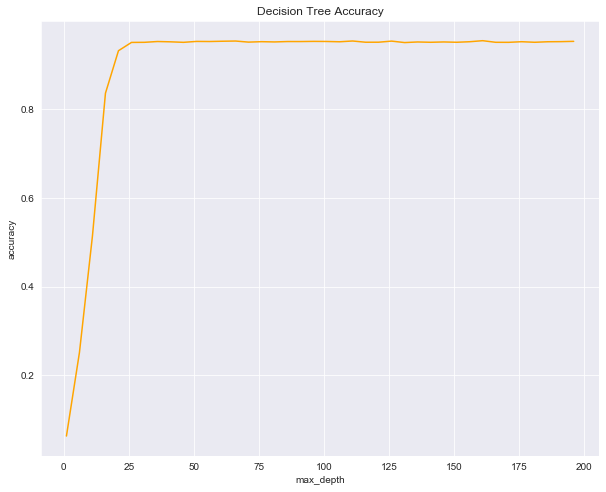

In [42]:
sns.set_style("darkgrid")
plt.figure(figsize = (10, 8))
ax = sns.lineplot(x="max_depth", y="accuracy", color = 'orange', data=dtaccdf)
ax.set_title('Decision Tree Accuracy')
plt.show()

Random Forest

In [131]:
#takes a LONG time to run
rfacc = []
for i in range(1,200, 5):
    rf = RandomForestClassifier(n_estimators=100, max_depth=i, random_state=0)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    rfacc.append(accuracy_score(y_test, y_pred))

In [100]:
rfaccdf = DataFrame()
rfaccdf['max_depth'] = range(1,200, 5)
rfaccdf['accuracy'] = rfacc
rfaccdf['accuracy_shift'] = rfaccdf['accuracy'].shift(-1)
rfaccdf['accuracy_shift'].fillna(0, inplace = True)
rfaccdf['difference'] = rfaccdf['accuracy'] - rfaccdf['accuracy_shift']
rfaccdf[rfaccdf['difference'] == 0].iloc[0]
rfaccdf

,max_depth,accuracy,accuracy_shift,difference
0,1,0.089752,0.588017,-0.498264
1,6,0.588017,0.949504,-0.361488
2,11,0.949504,0.993471,-0.043967
3,16,0.993471,0.997851,-0.004380
4,21,0.997851,0.998223,-0.000372
5,26,0.998223,0.998223,0.000000
6,31,0.998223,0.998388,-0.000165
7,36,0.998388,0.998058,0.000331
8,41,0.998058,0.998182,-0.000124
9,46,0.998182,0.998182,0.000000


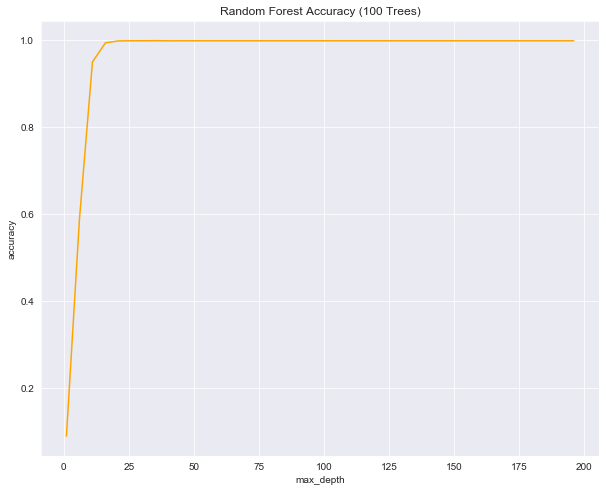

In [40]:
sns.set_style("darkgrid")
plt.figure(figsize = (10, 8))
ax = sns.lineplot(x="max_depth", y="accuracy", color = 'orange', data=rfaccdf)
ax.set_title('Random Forest Accuracy (100 Trees)')
plt.show()

## Test Set

Extracting images from test set

In [5]:
fruit_images_test = []
test_labels = []
for i in range(len(fruits_test)):
    image = cv2.imread(fruits_test['image path'][i], cv2.IMREAD_COLOR)
    image = cv2.resize(image, (45, 45))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)    
    fruit_images_test.append(image)
    test_labels.append(fruits_test['label'][i])
    
fruit_images_test = np.array(fruit_images_test)

#creating labels for images
test_labels = np.array(test_labels)
test_label2id = {v:i for i,v in enumerate(np.unique(test_labels))}
test_label_ids = np.array([test_label2id[x] for x in test_labels])

Transforming test images and running PCA with fit from train

In [262]:
test_images_scaled = scaler.transform([i.flatten() for i in fruit_images_test])
test_pca_result = pca.transform(test_images_scaled)

Getting PCA components into dataframe for features

In [263]:
testpcadf = DataFrame()
for i in range(50):
    testpcadf[i] = test_pca_result[:,i]
testpcadf

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-29.703067,-27.512025,-16.363825,10.795649,-34.988071,-20.666305,5.537662,7.724061,3.087127,4.427895,...,6.925348,3.504930,-3.703339,-0.456341,2.595227,2.285666,-0.884857,-1.827258,2.810557,-2.214923
1,-30.753675,-27.204525,-16.386146,10.674467,-34.965860,-20.993512,5.251701,8.038567,2.236752,4.298949,...,6.669201,3.039332,-4.023200,-0.565675,2.478846,1.779570,-0.785120,-1.715388,2.616258,-2.051668
2,-31.271748,-26.976306,-16.209512,10.601970,-34.886816,-21.430911,5.378892,8.311257,1.933968,4.186794,...,6.744189,2.752387,-3.963522,-0.836868,3.154880,1.380088,-0.669615,-1.733518,2.442883,-1.511410
3,-32.016714,-26.596497,-16.108439,10.327916,-34.960484,-21.604063,5.166525,8.436306,1.364181,4.076510,...,6.572532,2.240801,-4.067386,-0.812115,2.763104,1.234426,-0.798403,-1.841561,2.076792,-1.637080
4,-32.547926,-26.319505,-16.157973,10.245259,-34.847406,-21.840786,5.242212,8.714657,0.844709,3.884365,...,6.477940,2.091210,-4.368877,-0.721105,2.682584,0.970437,-0.919751,-1.654581,1.918794,-1.696733
5,-33.399855,-26.015134,-15.922116,9.961467,-34.781232,-22.132061,5.119442,8.968430,0.510171,4.225651,...,6.491914,2.103559,-4.480436,-0.885244,2.710767,0.402391,-0.870404,-1.588710,1.860900,-1.662169
6,-30.964678,-23.511777,-15.782015,8.770300,-36.752593,-18.798418,1.977911,11.411841,2.002801,1.820167,...,6.282371,0.342777,-3.293682,-1.025342,1.714180,1.563276,1.209635,-1.158348,3.147982,-1.327265
7,-46.118962,-21.192484,-16.492198,4.479443,-30.137220,-23.306271,7.249447,7.589491,0.227263,3.894792,...,8.691855,1.261631,-2.773268,1.634999,2.085092,1.686669,-0.413355,-0.917262,0.274552,-2.707446
8,-46.434158,-21.025333,-16.202565,4.343721,-30.041016,-22.873074,7.702001,7.270964,0.814373,3.951901,...,8.947640,1.640880,-2.247367,1.816402,2.684383,1.803478,-0.587652,-1.049706,0.622760,-2.675300
9,-47.169570,-20.972993,-16.791788,4.259576,-29.556186,-22.782323,7.309643,6.876885,0.678972,3.605653,...,8.516179,1.268459,-2.570253,1.896723,2.398365,1.605401,-0.570983,-1.225806,0.432166,-2.639621


Acutal Train/Test set

In [278]:
X_train = pcadf
X_test = testpcadf
y_train = label_ids
y_test = test_label_ids

## KNN

In [300]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
precision = (accuracy_score(test_label_ids, y_pred))*100
print("Accuracy with KNN: {0:.2f}%".format(precision))

Accuracy with KNN: 94.49%


## Decision Tree

In [258]:
dtree = DecisionTreeClassifier(max_depth = 36)
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)
precision = accuracy_score(y_pred, y_test)*100
print("Accuracy with Decision Tree: {0:.2f}%".format(precision))

Accuracy with Decision Tree: 73.21%


## Random Forest

In [252]:
rf = RandomForestClassifier(max_depth = 46)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
precision = accuracy_score(y_pred, y_test)*100
print("Accuracy with Random Forest Tree: {0:.2f}%".format(precision))

Accuracy with Random Forest Tree: 85.49%
